# Sentiment Analysis for Financial News

Groupe : Camille Leempoels <br>
Master : M2 MASH

The goal of this project is to do a supervised Sentiment Analysis on Financial Newspaper's Headlines, using a Neural Network built with Pytorch.

In [1]:
import pandas as pd
import numpy as np

# graphs
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
sns.set_context("paper")

# cleaning
import unidecode

# stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# vocab
from collections import Counter

# models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm  


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## Introduction

### Sentiment analysis

Sentiment Analysis is a method used Natural Language Processing. As the name suggests, the goal is generally to determine whether a given text expresses positive, negative, or neutral sentiment. This tool has a wide range of applications : social network monitoring, customer feedback, trading signal, and many others. 

To perform sentiment analysis, it is generally necessary to perform supervised learning on a large quantity of texts that have been previously labeled by a sentiment. Many models can be used to obtain convincing results, we will focus here on two types of neural networks: RNN and LSTM.

### Dataset

The dataset used in this project comes from kaggle (https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news). It contains 4846 headlines classified in three categories : positive, negative, neutral.

In [3]:
data = pd.read_csv('data.csv', encoding='latin-1', names=['sentiment','text'])

In [4]:
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


As shown on the graphic below, the classes are unbalanced. If a model predicts 'Neutral' for each headline, the accuracy will be 0.6%.

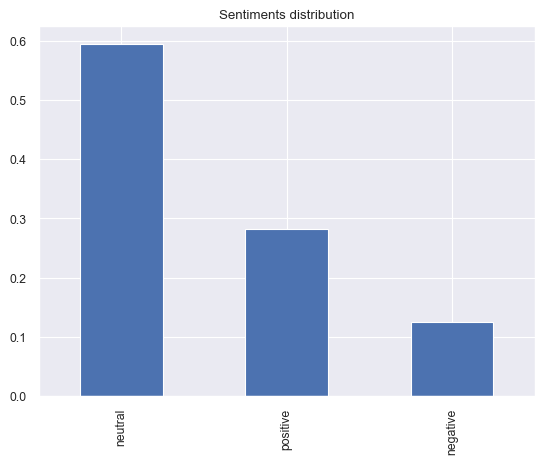

In [5]:
(data.sentiment.value_counts() / data.shape[0]).plot.bar();
plt.title('Sentiments distribution');

Before training the model, the text needs to be cleaned and pre-processed. To this effect we will :
* remove punctuation signs and special caracters
* replace upercases by lowercases so that the model understands that "Good" as the same meaning that "good"
* remove the numbers 
* remove very frequent words with little meaning


In [5]:
# Removing punctuation and special caracters
data['text'] = data['text'].str.replace('[^\w\s]', '', regex=True)
data['text'] = data['text'].str.replace('_', ' ')
data['text'] = data['text'].astype('unicode')
data['text'] = data['text'].transform(lambda x: unidecode.unidecode(x))

# Lowercase the text
data['text'] = data['text'].str.lower()

# Removing numbers
data['text'] = data['text'].str.replace('\d+', '', regex=True)

# Removing stop words
nltk_stopwords = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: [item for item in x.split() if item not in nltk_stopwords])

We now need to encode the sentences and words with integers. This is called the vocabulary. Before that, let's split the dataset into training set, validation set and test set so that we don't build the vocabulary using headlines we musn't see.

In [15]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=1, shuffle=True)
test_set, validation_set = train_test_split(test_set, test_size=0.5, random_state=2, shuffle=True)

The following method has been used to build the vocabulary :
* Count the number of occurences of each word
* Sort the words from the most frequent one to the least frequent one
* Associate 1 to the most frequent word, 2 to the second most frequent word,..., 8337 to the least frequent one
* When encoding headlines that are from validation and/or test set, unknown words will be associated to 8338

In [16]:
# extract all the words and count them
vocab = Counter([word for sentence in train_set['text'].values.tolist() for word in sentence])

print('Number of words in the training set : ' + str(sum(vocab.values())))
print('Number of unique words in the training set : ' + str(len(list(vocab))))

# Sort the words
vocab = vocab.most_common()

print('Most frequent words : ' + str(vocab[0:10]))

# convert the vocabulary to a Python Dict
vocab = dict(vocab)

# encode words as integers
sparse_vocab = {word:i for i, word in enumerate(vocab, 1)} 
inv_sparse_vocab = {v: k for k, v in sparse_vocab.items()}

# create an index for unknown words
unknown = len(list(vocab)) + 1

Number of words in the training set : 46400
Number of unique words in the training set : 8337
Most frequent words : [('eur', 1057), ('company', 680), ('mn', 475), ('said', 437), ('finnish', 405), ('sales', 354), ('million', 335), ('profit', 325), ('net', 323), ('finland', 278)]


Headlines need to be padded so that their encoded reprensentation all have the same length. To this extent, let's plot the histogram of the length of the headlines of the training set. We will then drop the sentences that are way too long compared to the rest of the dataset to avoid to add too much padding. The shortest sentences will also be dropped because they will have little meaning and lot of padding.

The padding will be represented with zeros. For example, if we want the length to be 5, then the sentence [17, 356, 47] will be transformed to [0, 0, 17, 356, 47].

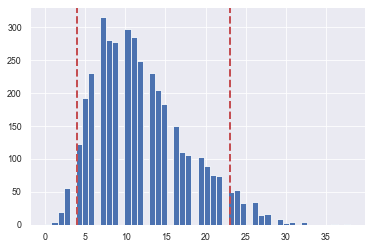

In [17]:
length = train_set['text'].apply(lambda sentence : len(sentence))
limit_low, limit_high  = length.quantile(q=[0.05, 0.95]).values
length.hist(bins=50);
plt.axvline(limit_low, color='r', linewidth=2, linestyle="dashed");
plt.axvline(limit_high, color='r', linewidth=2, linestyle="dashed");

In [18]:
def encode_text(data, limit_low = limit_low, limit_high = limit_high):
    # encode sentences and set -1 if the word is not in the vocabulary
    data['text_encoded'] = data['text'].apply(
        lambda sentence : [sparse_vocab.get(word, unknown) for word in sentence]
    )

    # drop sentences that are extremely short or long
    data['length'] = data['text_encoded'].apply(lambda sentence : len(sentence))
    data = data[(data['length'] <= limit_high) & (data['length'] >= limit_low)].copy()

    # pad sentences so that each vector has the same length
    max_len = int(limit_high)
    data['text_encoded'] = data.apply(lambda row: [0] * (max_len - row['length']) + row['text_encoded'], axis=1)
    data['length'] = data['text_encoded'].apply(lambda sentence : len(sentence))

    if sum(data['length'] != max_len):
        print('WARNING')

    return data

def decode(data):
    for encoded_sentence in data:
        print([inv_sparse_vocab.get(number, '') for number in encoded_sentence])

Let's encode the headlines of the training set, validation set and test set using the methods previously explained.

In [20]:
def format_tensors(set):
    txt = encode_text(set.copy())
    labels = txt['sentiment'].replace(['positive','neutral','negative'], [0, 1, 2])

    return torch.tensor(np.vstack(txt['text_encoded'])), torch.tensor(np.vstack(labels)).long()#.to(device)

train_txt, train_labels = format_tensors(train_set)
val_txt, val_labels = format_tensors(validation_set)
test_txt, test_labels = format_tensors(test_set)

validation_dataloader = DataLoader(
    TensorDataset(val_txt, val_labels), 
    batch_size = len(val_labels),
    shuffle = True
)

test_dataloader = DataLoader(
    TensorDataset(test_txt, test_labels), 
    batch_size = len(test_labels),
    shuffle = True
)

Since our sentiments classes are unbalanced, we will apply weights in the loss function.

In [30]:
labels_counts = torch.bincount(train_labels.squeeze())
weights = 1 - labels_counts / labels_counts.sum()

## Reccurent Neural Network

A RNN is a type of neural network used to process sequential data. Unlike classical neural networks which process each input independently, the RNN have what we could call an "internal memory" which allows the current state of the network to take into account previous states, also called 'cells'.

This is the method that will be used in this part of the project.

We could pass as inputs the data that we have just encoded, however it is particularly sparse and the representation of each word does not carry much sense as it only represents the frequency. We will therefore use a method called embedding to represent words in a more dense way. The advantage of the Embedding method is also that two words with a similar meaning will be represented by vectors that are close to each other in the vectorial space being considered.

In [33]:
class RNN_module(nn.Module):

    def __init__(self, vocab_dim, embedding_dim, hidden_dim):
        super().__init__()

        # embedding layer
        self.embedding_layer = nn.Embedding(vocab_dim, embedding_dim, padding_idx=0)
        # RNN layer
        self.rnn_layer = nn.RNN(embedding_dim, hidden_dim)
        # fully connected layer
        self.fc_layer = nn.Linear(hidden_dim, 3)

    def forward(self, txt):
        emb_txt = self.embedding_layer(txt.T)
        rnn_out, rnn_hidden = self.rnn_layer(emb_txt)
        fc_out = self.fc_layer(rnn_hidden.squeeze(0))
        return fc_out

The RNN is depends on many hyperparameters : the size of the embedding, the size of the RNN cells, the learning rate, the size of the batchs and the number of epochs. 

In order to choose the best combination of parameters, we will perform cross-validation and then compare the scores. The package Skorch will allow us to use the Sklearn GridSearchCV function with our Pytorch module.

In [36]:
from skorch import NeuralNetClassifier

rnn_net = NeuralNetClassifier(
    RNN_module,
    criterion = nn.CrossEntropyLoss(weight=weights),
    optimizer = torch.optim.SGD,
    # device = 'cuda',
    module__vocab_dim = len(vocab) + 2,
    module__embedding_dim = 50,
    module__hidden_dim = 32
)

In [42]:
param_grid = {
    'batch_size' : [16, 32],
    'max_epochs' : [50, 100],
    'lr' : [1e-2, 1e-3],
    'module__embedding_dim' : [50, 100, 150],
    'module__hidden_dim' : [50, 100]
}

grid = GridSearchCV(
    estimator=rnn_net, 
    param_grid=param_grid,
    n_jobs=-1,
    cv=10
)

# cv_res = grid.fit(train_txt, train_labels.squeeze())
# print("Best: %f using %s" % (cv_res.best_score_, cv_res.best_params_))
# print(cv_res.best_estimator_)
# pd.DataFrame(cv_res.cv_results_).to_csv('cv_res.csv', index = False)
cv_res_df = pd.read_csv('cv_res.csv')

Let's plot the results of the Cross Validation.

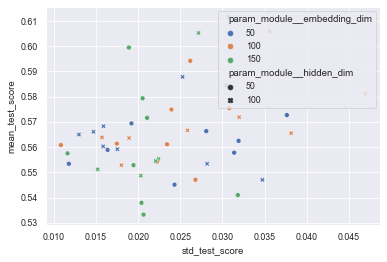

In [43]:
sns.scatterplot(
    data=cv_res_df, 
    y='mean_test_score', 
    x='std_test_score', 
    hue='param_module__embedding_dim', 
    style='param_module__hidden_dim', 
    palette="deep"
);

The gridsearch only looks at the best average test score, it doesn't take into account the standard deviation. By plotting the results, we can see that the parameters EMBEDDING_DIM = 150 and HIDDEN_DIM = 50 seem to lead to a good compromise between mean and standard deviation.

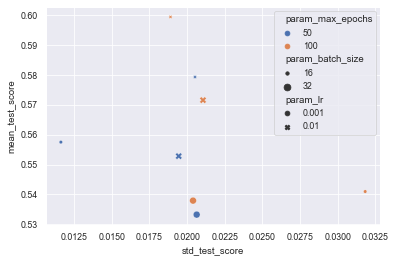

In [44]:
sns.scatterplot(
    data=cv_res_df.query('param_module__embedding_dim == 150 and param_module__hidden_dim == 50'), 
    y='mean_test_score', 
    x='std_test_score', 
    hue='param_max_epochs', 
    style='param_lr', 
    size='param_batch_size',
    palette="deep"
);

We will keep MAX_EPOCHS = 100, BATCH_SIZE = 16 and LR = 0.001.

Now, let's train and evaluate the model "by hand", using the chosen hyperparameters.

In [45]:
def train_epoch(dataloader, model, optimizer, loss_function):
    
    model.train()
    
    for txt, label in dataloader:

        # forward computation
        pred = model(txt)
        loss = loss_function(pred, label.squeeze())

        # backward computation
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()

In [46]:
def eval_epoch(dataset, model, loss_function, accuracy_function):
    
    model.eval()
    loss = []
    acc = []
    
    with torch.no_grad():

        for txt, label in dataset:

            pred = model(txt)
            loss.append(loss_function(pred, label.squeeze()).item())
            acc.append(accuracy_function(pred, label).item())
        
    return np.mean(loss), np.mean(acc)

In [47]:
def train_and_validate_model(model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, verbose = False, **kwargs):

    train_dataloader = DataLoader(
        TensorDataset(train_txt, train_labels), 
        batch_size = BATCH_SIZE,
        shuffle=True
    )

    loss_function = nn.CrossEntropyLoss(weight=weights)
    accuracy_function = lambda pred, target : torch.sum((torch.argmax(torch.softmax(pred, dim=1), dim=1) == target.T)) / len(target)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    train_loss_array = []
    train_accuracy_array = []
    val_loss_array = []
    val_accuracy_array = []

    for epoch in tqdm(range(EPOCHS)):
        # training
        train_epoch(train_dataloader, model, optimizer, loss_function)

        # compute loss and accuracy metrics
        train_loss, train_accuracy = eval_epoch(train_dataloader, model, loss_function, accuracy_function)
        val_loss, val_accuracy = eval_epoch(validation_dataloader, model, loss_function, accuracy_function)

        train_loss_array.append(train_loss)
        train_accuracy_array.append(train_accuracy)
        val_loss_array.append(val_loss)
        val_accuracy_array.append(val_accuracy)

        if verbose:
            print('EPOCH : ' + str(epoch + 1))
            print('Training loss : ' + str(train_loss) + ' | Training accuracy : ' + str(train_accuracy))
            print('Validation loss : ' + str(val_loss) + ' | Validation accuracy : ' + str(val_accuracy))

    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout = True, figsize = (10,10))

    sns.lineplot(x=range(EPOCHS), y=train_loss_array, ax=ax1, label='Training set')
    sns.lineplot(x=range(EPOCHS), y=val_loss_array, ax=ax1, label='Validation set')
    ax1.set_xlabel('Epochs')
    ax1.set_title('Loss')
    ax1.legend();

    sns.lineplot(x=range(EPOCHS), y=train_accuracy_array, ax=ax2, label='Training set')
    sns.lineplot(x=range(EPOCHS), y=val_accuracy_array, ax=ax2, label='Validation set')
    ax2.set_xlabel('Epochs')
    ax2.set_title('Accuracy')
    ax2.legend();

    title = 'RNN | Batch size : ' + str(BATCH_SIZE) + ' | LR : ' + str(LEARNING_RATE) + ' | Embedding : ' + str(EMBEDDING_DIM) + ' | Hidden : ' + str(HIDDEN_DIM) 
    for key, value in kwargs.items():
        title = title + ' | ' + str(value)

    fig.suptitle(title);

    return("Test set accuracy: %f" % eval_epoch(test_dataloader, model, loss_function, accuracy_function)[1])

100%|██████████| 150/150 [08:49<00:00,  3.53s/it]


'Test set accuracy: 0.565410'

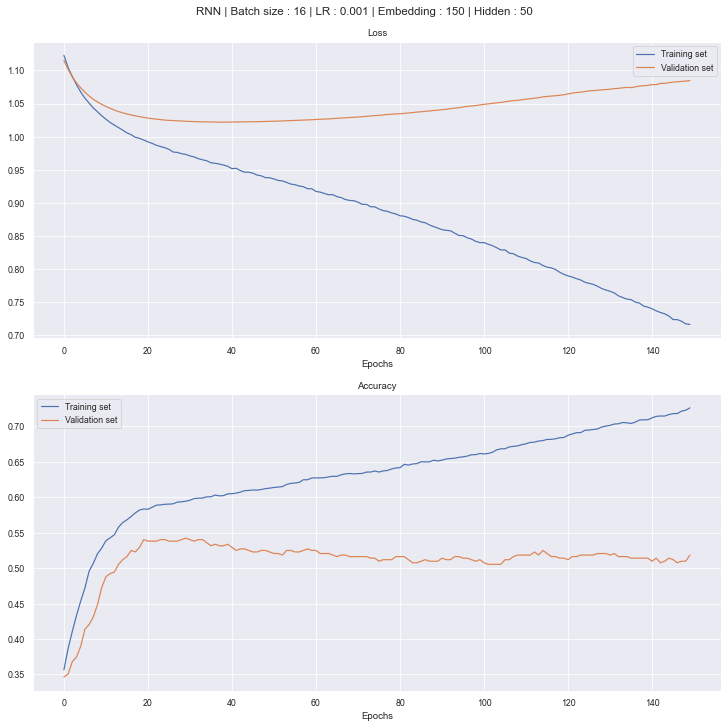

In [76]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM = 150
HIDDEN_DIM = 50
LEARNING_RATE = 1e-3
EPOCHS = 150
BATCH_SIZE = 16

rnn_model = RNN_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM)

train_and_validate_model(rnn_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE)

Even with finetuned hyperparameters, the accuracy is low. We are trying a more sophisticated model in the next section.

## LSTM Neural Network

The problem with RNN is that the information they store in their hidden cells gets diluted and lost over time. This is an issue if meaningful words are localised at the beginning of the headlines.

A LSTM (Long Short Term Memory) neural network solves this problem by using gates to control the flow of information through the network. These gates decide whether the words are worth being remembered of should be forgotten.

In [63]:
class LSTM_module(nn.Module):

    def __init__(self, vocab_dim, embedding_dim, hidden_dim, nb_lstm_layers, dropout):
        super().__init__()
        # hyperparameters
        self.vocab_dim = vocab_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.nb_lstm_layers = nb_lstm_layers
        self.dropout = dropout

        # embedding layer
        self.embedding_layer = nn.Embedding(
            self.vocab_dim, 
            self.embedding_dim, 
            padding_idx=0
            )

        # RNN layer
        self.lstm_layer=nn.LSTM(
            input_size=self.embedding_dim, 
            hidden_size=self.hidden_dim,
            num_layers=self.nb_lstm_layers,
            batch_first=True,
            dropout=self.dropout
        )
        self.dropout = nn.Dropout(self.dropout)

        # fully connected layer
        self.fc_layer = nn.Linear(self.hidden_dim, 3)

    def forward(self, txt):

        emb_txt = self.embedding_layer(txt)
        lstm_out, _ = self.lstm_layer(emb_txt)
        output = self.dropout(lstm_out[:,-1,:])
        fc_out = self.fc_layer(output)
        
        return fc_out

In this model we have to specify two other hyperparameters: the number of cells in the LSTM layer and the "dropout", a probability that a node of the network will be set to zero to avoid overfitting.

The total number of parameters to train in this model is higher than in the RNN, which means that my computer is not able to perform cross-validation in a reasonable amount of time. Therefore, I manually tested several parameter combinations and will display two of them.

100%|██████████| 100/100 [06:58<00:00,  4.19s/it]


'Test set accuracy: 0.713969'

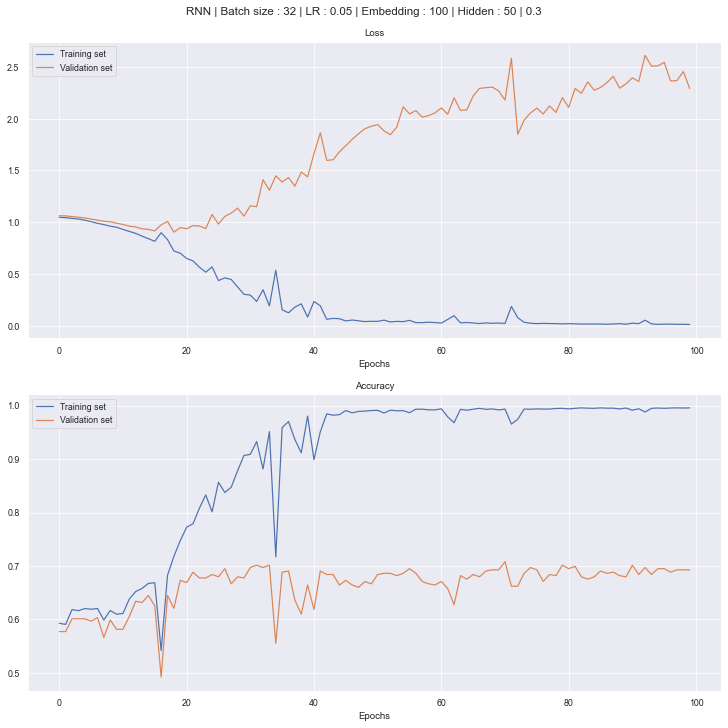

In [52]:
VOCAB_DIM = len(vocab) + 2
EMBEDDING_DIM =100
HIDDEN_DIM = 50
DROPOUT = 0.3
NB_LAYERS = 2

LEARNING_RATE = 5*1e-2
EPOCHS = 100
BATCH_SIZE = 32 

lstm_model = LSTM_module(VOCAB_DIM, EMBEDDING_DIM, HIDDEN_DIM, NB_LAYERS, DROPOUT)

train_and_validate_model(lstm_model, EMBEDDING_DIM, HIDDEN_DIM, LEARNING_RATE, EPOCHS, BATCH_SIZE, DROPOUT=DROPOUT)